# 2. An example of a landscape evolution model

To create a mountain environment we will use [Fastscape](https://fastscape.readthedocs.io/en/latest/), which is a tool to efficiently solve the basic equation explained before and which contains the minimum set of processes that control the evolution of a landscape ([Braun & Willett, 2003](https://www.sciencedirect.com/science/article/pii/S0169555X12004618?via%3Dihub)).

## Import libraries

First, we would need to import relevant librarires to produce and analyze the results of a landscape evolution model. Some of these libraries are: [basic model](https://fastscape.readthedocs.io/en/latest/models.html) a model with the simple processes explain before, [xarray-simlab](https://xarray-simlab.readthedocs.io/en/latest/) the main modelling framework on which Fastscape is build, [numpy](https://numpy.org/) is a powerful library with several functions to work with arrays, [matplotlib](https://matplotlib.org/) is a comprehensive library to visualize various type of data, [hvplot](https://hvplot.holoviz.org/) is a library for interactive visualization and exploration of the data and [TopoViz3d](https://github.com/fastscape-lem/ipyfastscape) is a custom made 3D visualization made for Fastscape and similar type of data. We can import these libraries by typing:

In [1]:
from fastscape.models import basic_model
import numpy as np
import xsimlab as xs
%load_ext xsimlab.ipython
import matplotlib.pyplot as plt 
import hvplot.xarray
from ipyfastscape import TopoViz3d

## Inspect the model

Models build on xarray-simlab have several useful functionallity to [create/modify](https://xarray-simlab.readthedocs.io/en/latest/create_model.html), [inspect](https://xarray-simlab.readthedocs.io/en/latest/inspect_model.html), [setup and run](https://xarray-simlab.readthedocs.io/en/latest/run_model.html) a model. We will explore some of those options later but it helps to get familiar with the model we are going to work with if we visualize its components by simply typing:
```python
basic_model
```
or
```python
basic_model.visualize()
```
from the [visualize method](https://xarray-simlab.readthedocs.io/en/latest/_api_generated/xsimlab.Model.visualize.html) we can explore more information, e.g. the input variables:
```python
basic_model.visualize(show_inputs=True)
```

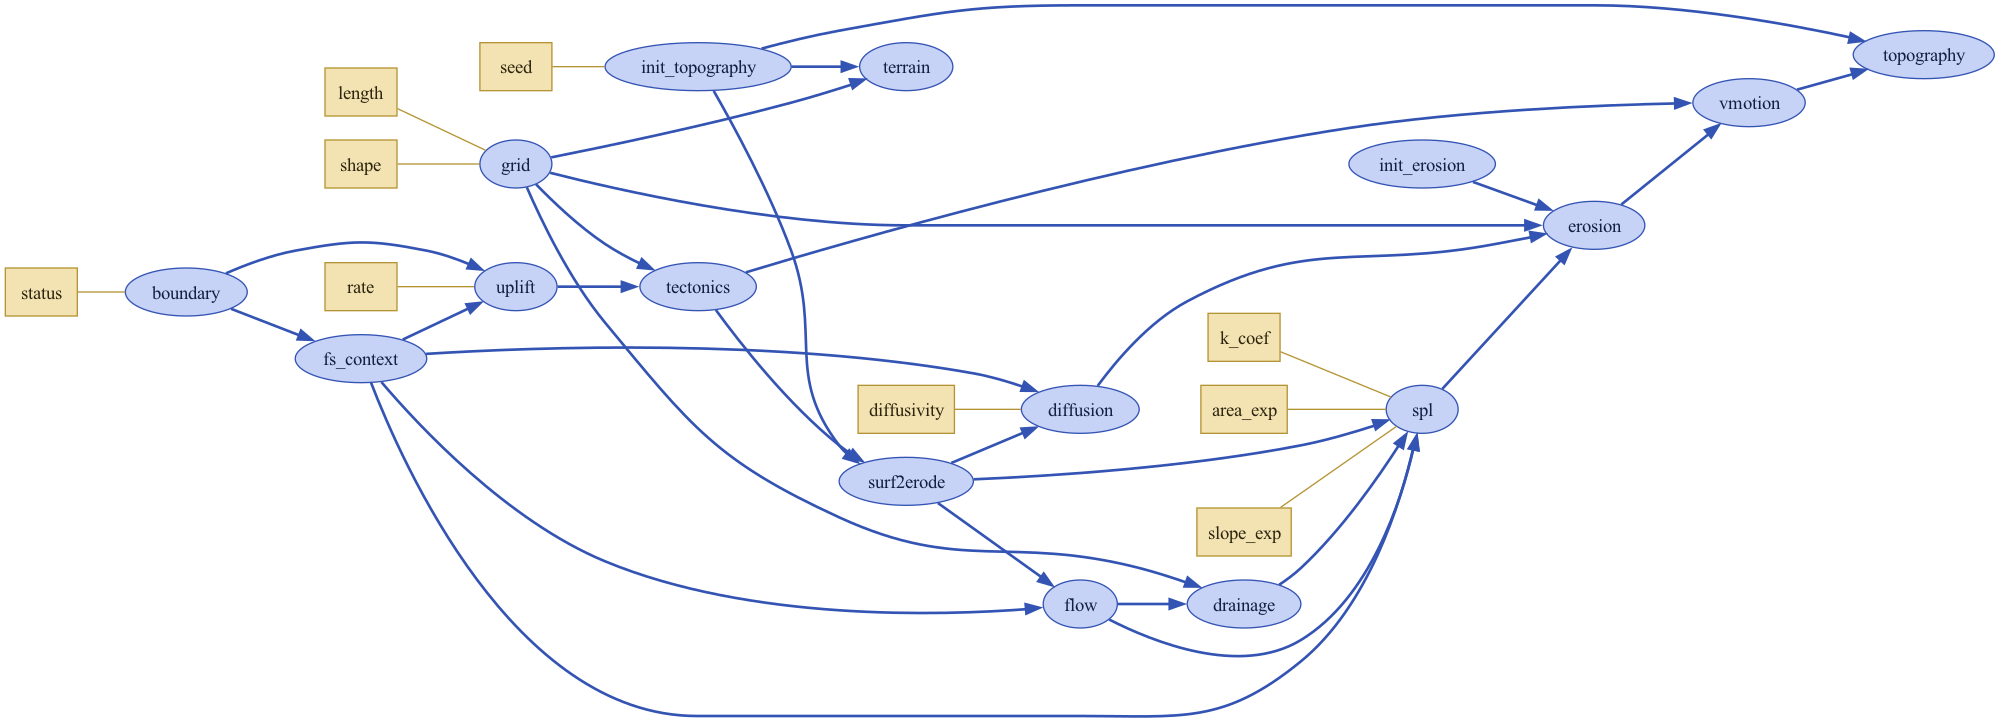

In [2]:
basic_model.visualize(show_inputs=True)

## Create a model setup 

First thing we need to do is to create a setup for our model. Lets start by typing the following command in the window below:
```python 
%create_setup basic_model --default --verbose
```

You wil see that we need to specify several parameters. First, lets specify the clocks to use in our simulation. In particular we need to specifiy the actual clock we use to compute the solution also called the **master clock** and another clock to save the output of the model **out clock**. The latter commonly has less elements than the master clock. To create these clocks lets assume we will model the evolution of an orogen for 10 Myr. Then we will create an array that contains 1000 elements from 0 to 10 million using [numpy.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) function as:
```python 
the_clock = np.linspace(0, 10e6, 1001) 
```

We then specify both clocks as a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), where the **time clock** is the clock array and the **out clock** is a subsample of 100 elements of the clock array:
```python 
clocks = {'time': the_clock,
         'out': the_clock[::10]}
```

Since we pass two clocks to our setup, we would need to let the program know which of these two clocks is the **master clock**. We do that by adding the following option to our setup:
```python
master_clock='time',
```

Second we need to specify the grid dimensions by passing a [list](https://docs.python.org/3/tutorial/introduction.html#lists) with the number of grid nodes for the y and x coordiantes, which we will consider to be 100 by 100 grid nodes and can be specified this way:
```python
nx=101
ny=101
input_vars={
    'grid__shape': [ny, nx],
    ...
    }
```
and these nodes will have a maximum extend of 100 by 100 km, which one can specify as:
```python
lx=100e3
ly=100e3
input_vars={
    ...
    'grid__length': [ly, lx],
    ...
}
```

Then we need to specify the [boundary conditions](https://fastscape.readthedocs.io/en/latest/_api_generated/fastscape.processes.BorderBoundary.html#fastscape.processes.BorderBoundary) for the grid nodes in the border.
We can do this by passing a list in the order [left, right, top, bottom] and where the border status can be 
“core” (open boundary), “fixed_value” (closed boundary) and “looped” (periodic boundary). Note tha at least one of 
the border needs to be “fixed_value”. For our case we will consider:

```python
input_vars={
    ...
    'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
    ...
}
```

Third, we will need to specify the parameters related to the basic equation governing landscape evolution. Particularly we will assume a constant **uplift rate** of $10^{-3}$ m/yr, a **bedrock incision coefficient** of $10^{-5}$ m/yr and a **hillslope transport coefficient** of $10^{-2}$ as:

```python
input_vars={
    ...
    'uplift__rate': 1e-3,
    'spl__k_coef': 1e-5,
    ...
    'diffusion__diffusivity': 1e-2,
    ...
    }
```
The other input parameters we will leave with their defaul value.

The last part that we need to specify in the setup is which variables we would like to retrieve. We can do that by passing a dictionary as:
```python
output_vars={'topography__elevation': 'out'}
```

In [3]:
# %create_setup basic_model --default --verbose
the_clock = np.linspace(0, 10e6, 1001) 
nx=101
ny=101
lx=100e3
ly=100e3

ds_in = xs.create_setup(
    model=basic_model,
    clocks = {'time': the_clock,
         'out': the_clock[::10]},
    master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny, nx],
        # total grid length in (y, x)
        'grid__length': [ly, lx],
        # node status at borders
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'] ,
        # uplift rate
        'uplift__rate': 1e-3,
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # random seed
        'init_topography__seed': None,
    },
    output_vars={'topography__elevation': 'out'}
)

## Run the model

To run the model we will use the model setup we just created **ds_in** and use a method from xarray-simlab library called **run** to compute our solution, which will be stored into the versatile data format called [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html):
```python
with basic_model, xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run()
```
For the execution of the model we will use the [with statement](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement). This is a context manager that allows to execute a model with methods that will only be accesible during the computation, e.g. the basic_model and a progress bar to monitor the computation of the model. 

In [4]:
with basic_model, xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run()

             0% | initialize 

## Visualize the solution

Now lets explore the results of the model. First we can check what variables are contained in our **ds_out** dataset by typing: 

In [5]:
ds_out

<xarray.Dataset>
Dimensions:                 (border: 4, shape_yx: 2, out: 101, time: 1001,
                             y: 101, x: 101)
Coordinates:
  * border                  (border) object 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+05 2e+05 ... 9.9e+06 1e+07
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.99e+06 1e+07
  * x                       (x) float64 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
  * y                       (y) float64 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status        (border) <U11 'looped' 'looped' ... 'fixed_value'
    diffusion__diffusivity  float64 0.01
    grid__length            (shape_yx) float64 1e+05 1e+05
    grid__shape             (shape_yx) int64 101 101
    init_topography__seed   float64 nan
    spl__area_exp           float64 0.4
    spl__k_coef             float64 1e-05
    spl__slope_exp          int64 1
    topography__elevation   (out, y, x) float64 0.3508 0.1984 ... 0.4521 0.8828
    uplift__rate            float64 0.001

Now lets plot the output variable **topography__elevation**, which have dimensions (out, y, x). Lets select the topography for the last time step and display it using the build-in [plotting routines](https://docs.xarray.dev/en/stable/user-guide/plotting.html), which are based on the matplotlib library:
```python
ds_out.topography__elevation.isel(out=-1).plot()
```

or to look at the maximum or average elevation over time one can do:
```python
ds_out.topography__elevation.max(('x', 'y')).plot()

ds_out.topography__elevation.mean(('x', 'y')).plot()
```

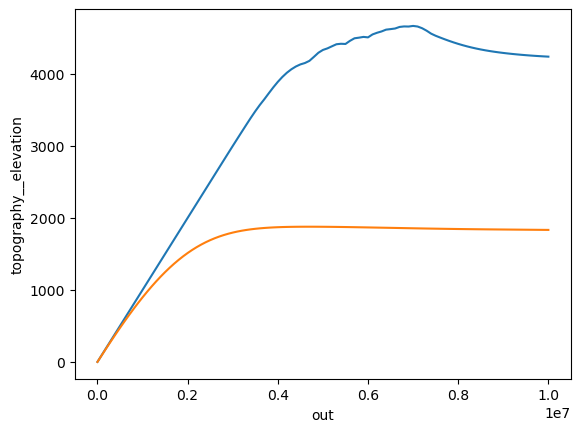

In [6]:
ds_out.topography__elevation.max(('x', 'y')).plot()
ds_out.topography__elevation.mean(('x', 'y')).plot()

Or we can plot the results at selected time steps

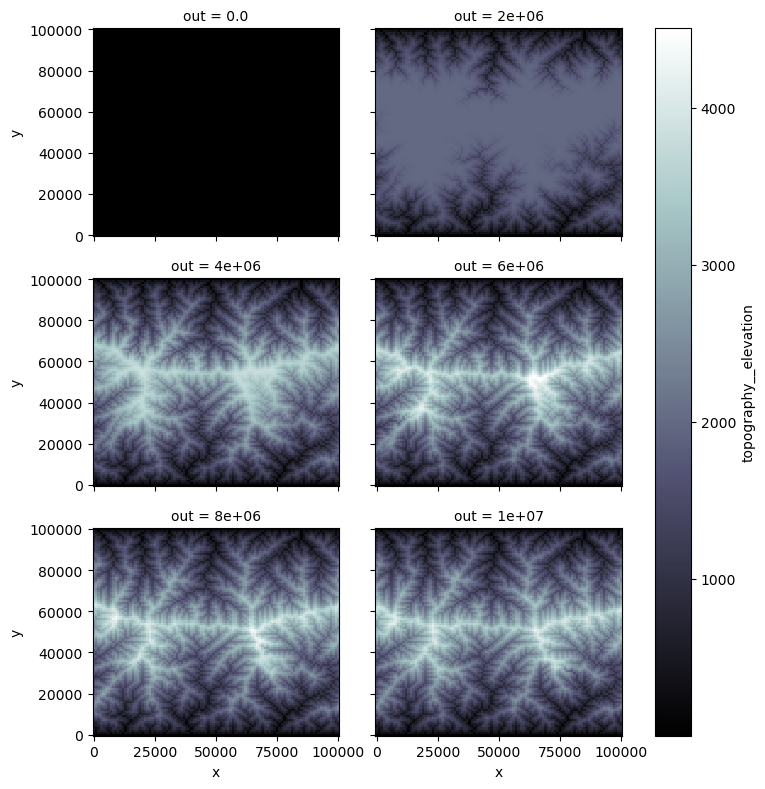

In [7]:
time_sel = np.arange(0, 11e6, 2e6)
ds_out.sel(out=time_sel).topography__elevation.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='bone')